# Notebook to compare results to gPhoton
Setup your source parameter and setting in the cell below.

In [1]:
region_name = "ALL_10-800" 
outdir = "./resources/gPhoton_out/"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"

srcs_ids = [4993 ,13580 ,14504 ,30475 ,50388 ,52994 ,79477 ,120265 ,138783 ,139480 ,162697 ,204419 ,221349 ,228958 ,236839 ,253214 ,253670
            ,256433 ,261213 ,331466 ,340464 ,381336 ,390864 ,489430 ,498065 ,525310 ,532554 ,533185 ,540235 ,583838 ,639720 ,645215 ,645730
            ,659787 ,666224 ,673175 ,680119 ,691408 ,714140 ,764827 ,1037284 ,1069077 ,1070938 ,1805505 ,1839206 ,2527679 ,3074917 ,] 
#srcs_ids = [4993]
srcs_ids = [193067 ,432606 ,535864 ,451644 ,1551422 ,541266 ,581995 ,625693 ,187856 ,8215 ,494782 ,166179 ,172775 ,34658 ,98746 ,
            1521738 ,2136829 ,297278 ,426363 ,426330 ,151796 ,305192 ,259271 ,388172 ,265150 ,54184 ,472623 ,419001 ,25273 ,26195 ,32448 ,199832 ,]# WD ALL_10-800

In [2]:
%matplotlib widget
import ipywidgets as widgets
import gPhoton
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table, join, vstack, MaskedColumn
from astropy import units as uu
import os
from vasca.utils import mag2flux, flux2mag, tgalex_to_astrotime
import vasca.visualization as vvis
from vasca.region import Region
from vasca.resource_manager import ResourceManager
import warnings
warnings.filterwarnings('ignore')

rg = Region()
rg.load_from_fits(region_fname)

#Subselect sources based on choice
if len(srcs_ids)>0:
    rg.tt_sources.add_index("rg_src_id")
    idx_srcs = rg.tt_sources.loc_indices["rg_src_id", srcs_ids]
    tt_srcs = Table(rg.tt_sources[idx_srcs])
else:
    tt_srcs = rg.tt_sources


#display(tt_srcs)

### Do aperture photometry for each visit with gPhoton

Skipping src_id 451644
Skipping src_id 581995
Skipping src_id 187856
Skipping src_id 494782
Skipping src_id 34658
Skipping src_id 426363
Skipping src_id 426330
Skipping src_id 419001
Skipping src_id 25273
Skipping src_id 26195
Nr of points all/matched: 1635 / 725


time_gp,time_bin_size_gp,flux_gp,flux_err_gp,sel_gp,obs_filter_gp,obs_filter_id,flags,s2n,rg_src_id,rtime,time_src,time_bin_size_src,flux_src,flux_err_src,ul,sel_src,obs_filter_src,r_fov,artifacts,class_star,chkobj_type,size_world,ellip_world,flux_auto,flux_auto_err,pull,pull_auto
d,s,1e-06 Jy,1e-06 Jy,,,,,,,,d,s,1e-06 Jy,1e-06 Jy,1e-06 Jy,,,deg,,,,arcsec,,Jy,Jy,1e-06 Jy,1e-06 Jy
float64,float32,float32,float32,bool,bytes8,int32,int64,float32,int64,float64,float64,float32,float32,float32,float32,bool,bytes8,float32,int64,float32,int32,float32,float32,float32,float32,float32,float32
53916.29374415509,979.0,38.753586,5.194577,False,FUV,2,4,8.728303,193067,53916.29,53916.29372685195,976.0,80.08072,10.0863085,-1.0,True,FUV,0.33658302,0,0.983571,0,2.6583416,0.10032165,76.8698,9.494286,-4.0973496,-4.0146475
53916.503339062496,1703.0,39.595673,3.6151028,False,FUV,2,4,12.502364,193067,53916.5,53916.503339120696,1703.0,61.7839,5.8269005,-1.0,True,FUV,0.37498164,0,0.9837746,0,2.5610788,0.041374072,58.040627,5.420223,-3.8078957,-3.402988
52992.04042239583,141.0,27.13243,6.3510666,False,FUV,2,8,5.3178163,535864,52992.04,52992.040422453705,141.0,51.978,7.2964883,-1.0,True,FUV,0.38446996,0,0.983483,0,2.4237053,0.16841763,48.665028,6.7873874,-3.405141,-3.172443
55325.11961799768,1452.0,131.92586,2.057172,False,NUV,1,512,64.55134,1521738,55325.12,55325.11960098447,1449.05,143.93462,2.2533138,-1.0,True,NUV,0.4316035,0,0.9900293,0,3.9035373,0.25925085,154.03447,2.2596562,-5.329377,-9.7840605
55326.35038767361,1227.0,128.62845,2.214245,False,NUV,1,512,58.8262,1521738,55326.35,55326.35037065978,1224.05,135.97266,2.4122224,-1.0,True,NUV,0.41641372,0,0.996984,0,3.9038453,0.15167749,146.39255,2.4404914,-3.0445817,-7.2789025
55329.36273142361,1340.0,132.7633,2.1421266,False,NUV,1,512,62.808514,1521738,55329.36,55329.362714410185,1337.05,141.5098,2.355419,-1.0,True,NUV,0.4083551,0,0.98502773,0,3.6051848,0.193422,148.9611,2.3368366,-3.7133482,-6.931507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55421.03929392361,1388.0,57.26804,2.2023215,True,NUV,1,0,27.36934,54184,55421.04,55421.03568576376,764.5,63.566185,1.7631398,-1.0,True,NUV,0.31039163,0,0.95560265,0,4.612538,0.45976132,72.67789,2.4641373,-3.572119,-6.253648


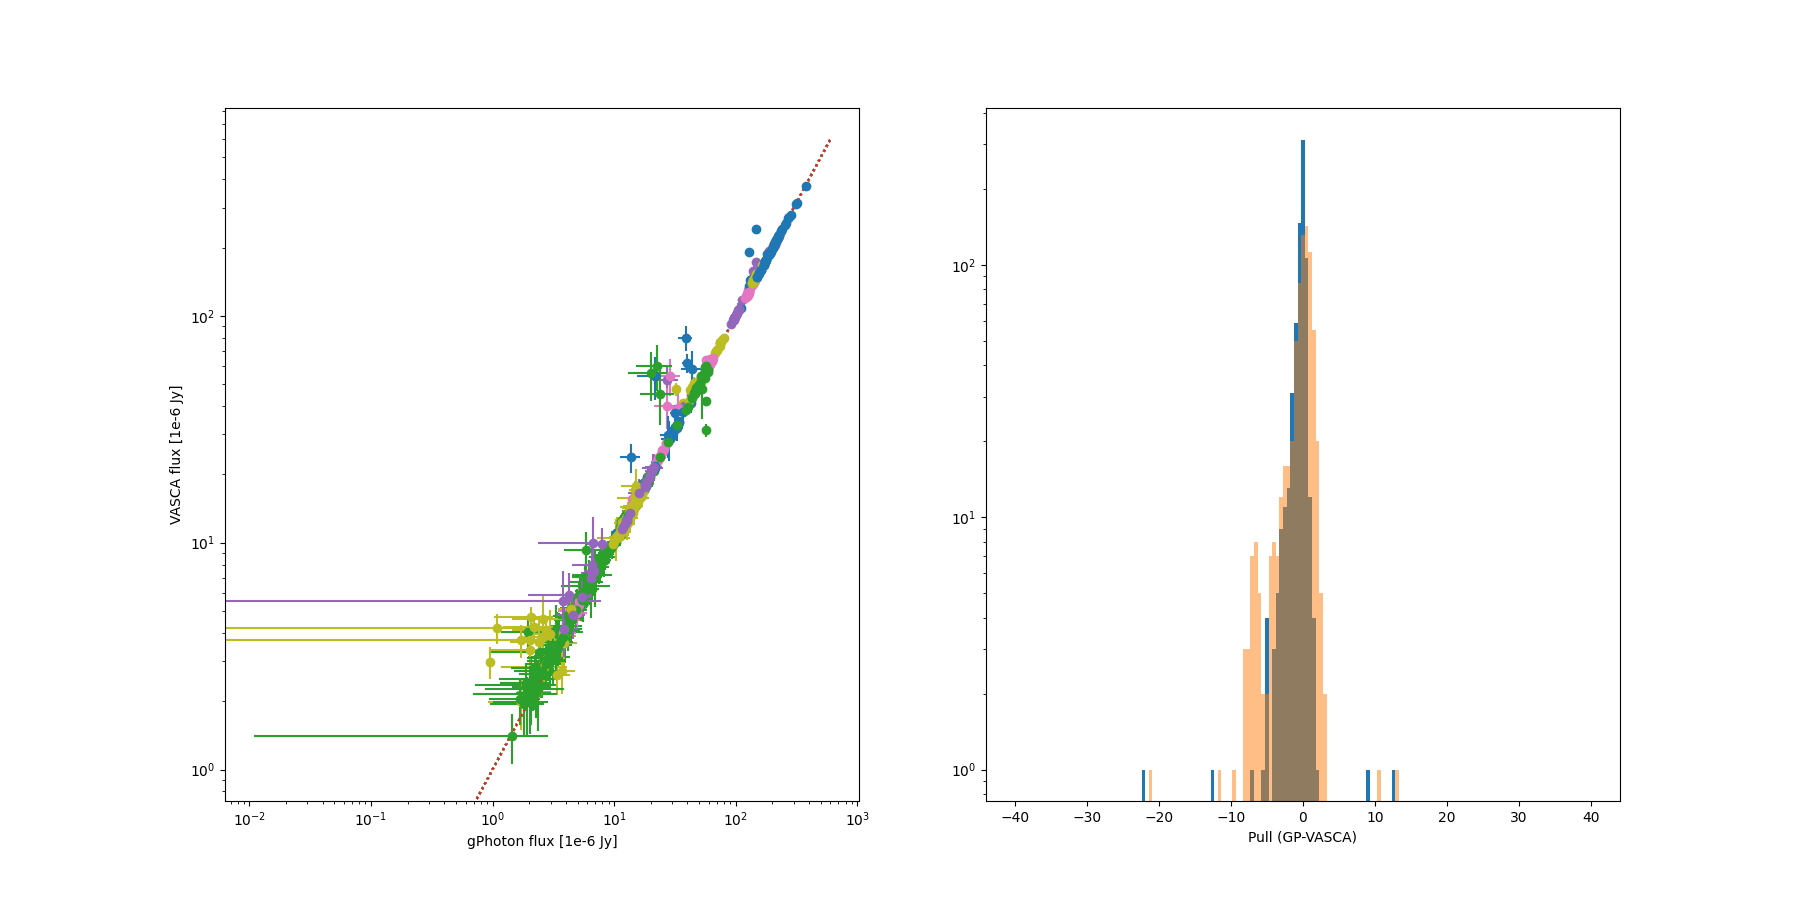

In [3]:
fig, axs = plt.subplots(1,2,figsize=(18, 9), squeeze=True, num="gPhotFlux", clear=True) 
axs = axs.flatten()
ll_lc = []
for rg_src_id in srcs_ids:

    #Get source
    tc_src = rg.get_src_from_id(rg_src_id, load_from_file = True, add_sed=False,add_gphoton=True, add_spectrum=False)

    if "tt_gphoton_lc" not in tc_src._table_names:
        print(f"Skipping src_id {rg_src_id}")
        continue
    
    tt_gp_lc = tc_src.tt_gphoton_lc
    tt_gp_lc["rg_src_id"] = rg_src_id
    tt_gp_lc["rtime"]=np.round(tt_gp_lc["time"],2)
    tt_src_lc = tc_src.tt_source_lc
    tt_src_lc["rtime"]=np.round(tt_src_lc["time"],2)
    tt_lc = join(tt_gp_lc,tt_src_lc,keys=['obs_filter_id',"rtime"],join_type='outer',table_names=["gp","src"])
    tt_lc["time_gp"] = MaskedColumn(tt_lc["time_gp"])
    tt_lc["time_src"]= MaskedColumn(tt_lc["time_src"])
    #display(tt_lc)
    sel_both = ~tt_lc["time_gp"].mask*~tt_lc["time_src"].mask
    tt_lc_both = tt_lc[sel_both]
    #sel_gp = tt_lc_both["sel_gp"]#*tt_lc_both["s2n"]>3

    ll_lc.append(tt_lc)
    #display(tt_lc[sel_both])
    
    #axs[0].plot(,"o")
    axs[0].errorbar(tt_lc_both["flux_gp"],tt_lc_both["flux_src"], xerr=tt_lc_both["flux_err_gp"], yerr=tt_lc_both["flux_err_src"],linestyle="none",marker="o")
    axs[0].set_xlabel("gPhoton flux [1e-6 Jy]")
    axs[0].set_ylabel("VASCA flux [1e-6 Jy]")
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[0].plot(range(600),range(600),":")
tt_lc = vstack(ll_lc)
sel_both = (~tt_lc["time_gp"].mask*~tt_lc["time_src"].mask)#*tt_lc["sel_gp"]
tt_lc_both = tt_lc[sel_both]
tt_lc_both["pull"] = (tt_lc_both["flux_gp"]-tt_lc_both["flux_src"])/tt_lc_both["flux_err_src"]
tt_lc_both["pull_auto"] = (tt_lc_both["flux_gp"]-tt_lc_both["flux_auto"])/tt_lc_both["flux_auto_err"]
axs[1].hist(tt_lc_both["pull"],bins=np.linspace(-40,40,160))
axs[1].hist(tt_lc_both["pull_auto"],bins=np.linspace(-40,40,160), alpha=0.5)
axs[1].set_yscale("log")
axs[1].set_xlabel("Pull (GP-VASCA)")
print("Nr of points all/matched:",len(tt_lc),"/",len(tt_lc_both))
display(tt_lc_both[np.abs(tt_lc_both["pull"])>3.])
#display(tt_lc_both[np.abs(tt_lc_both["pull"])>3.][12:])
#display(tt_lc)


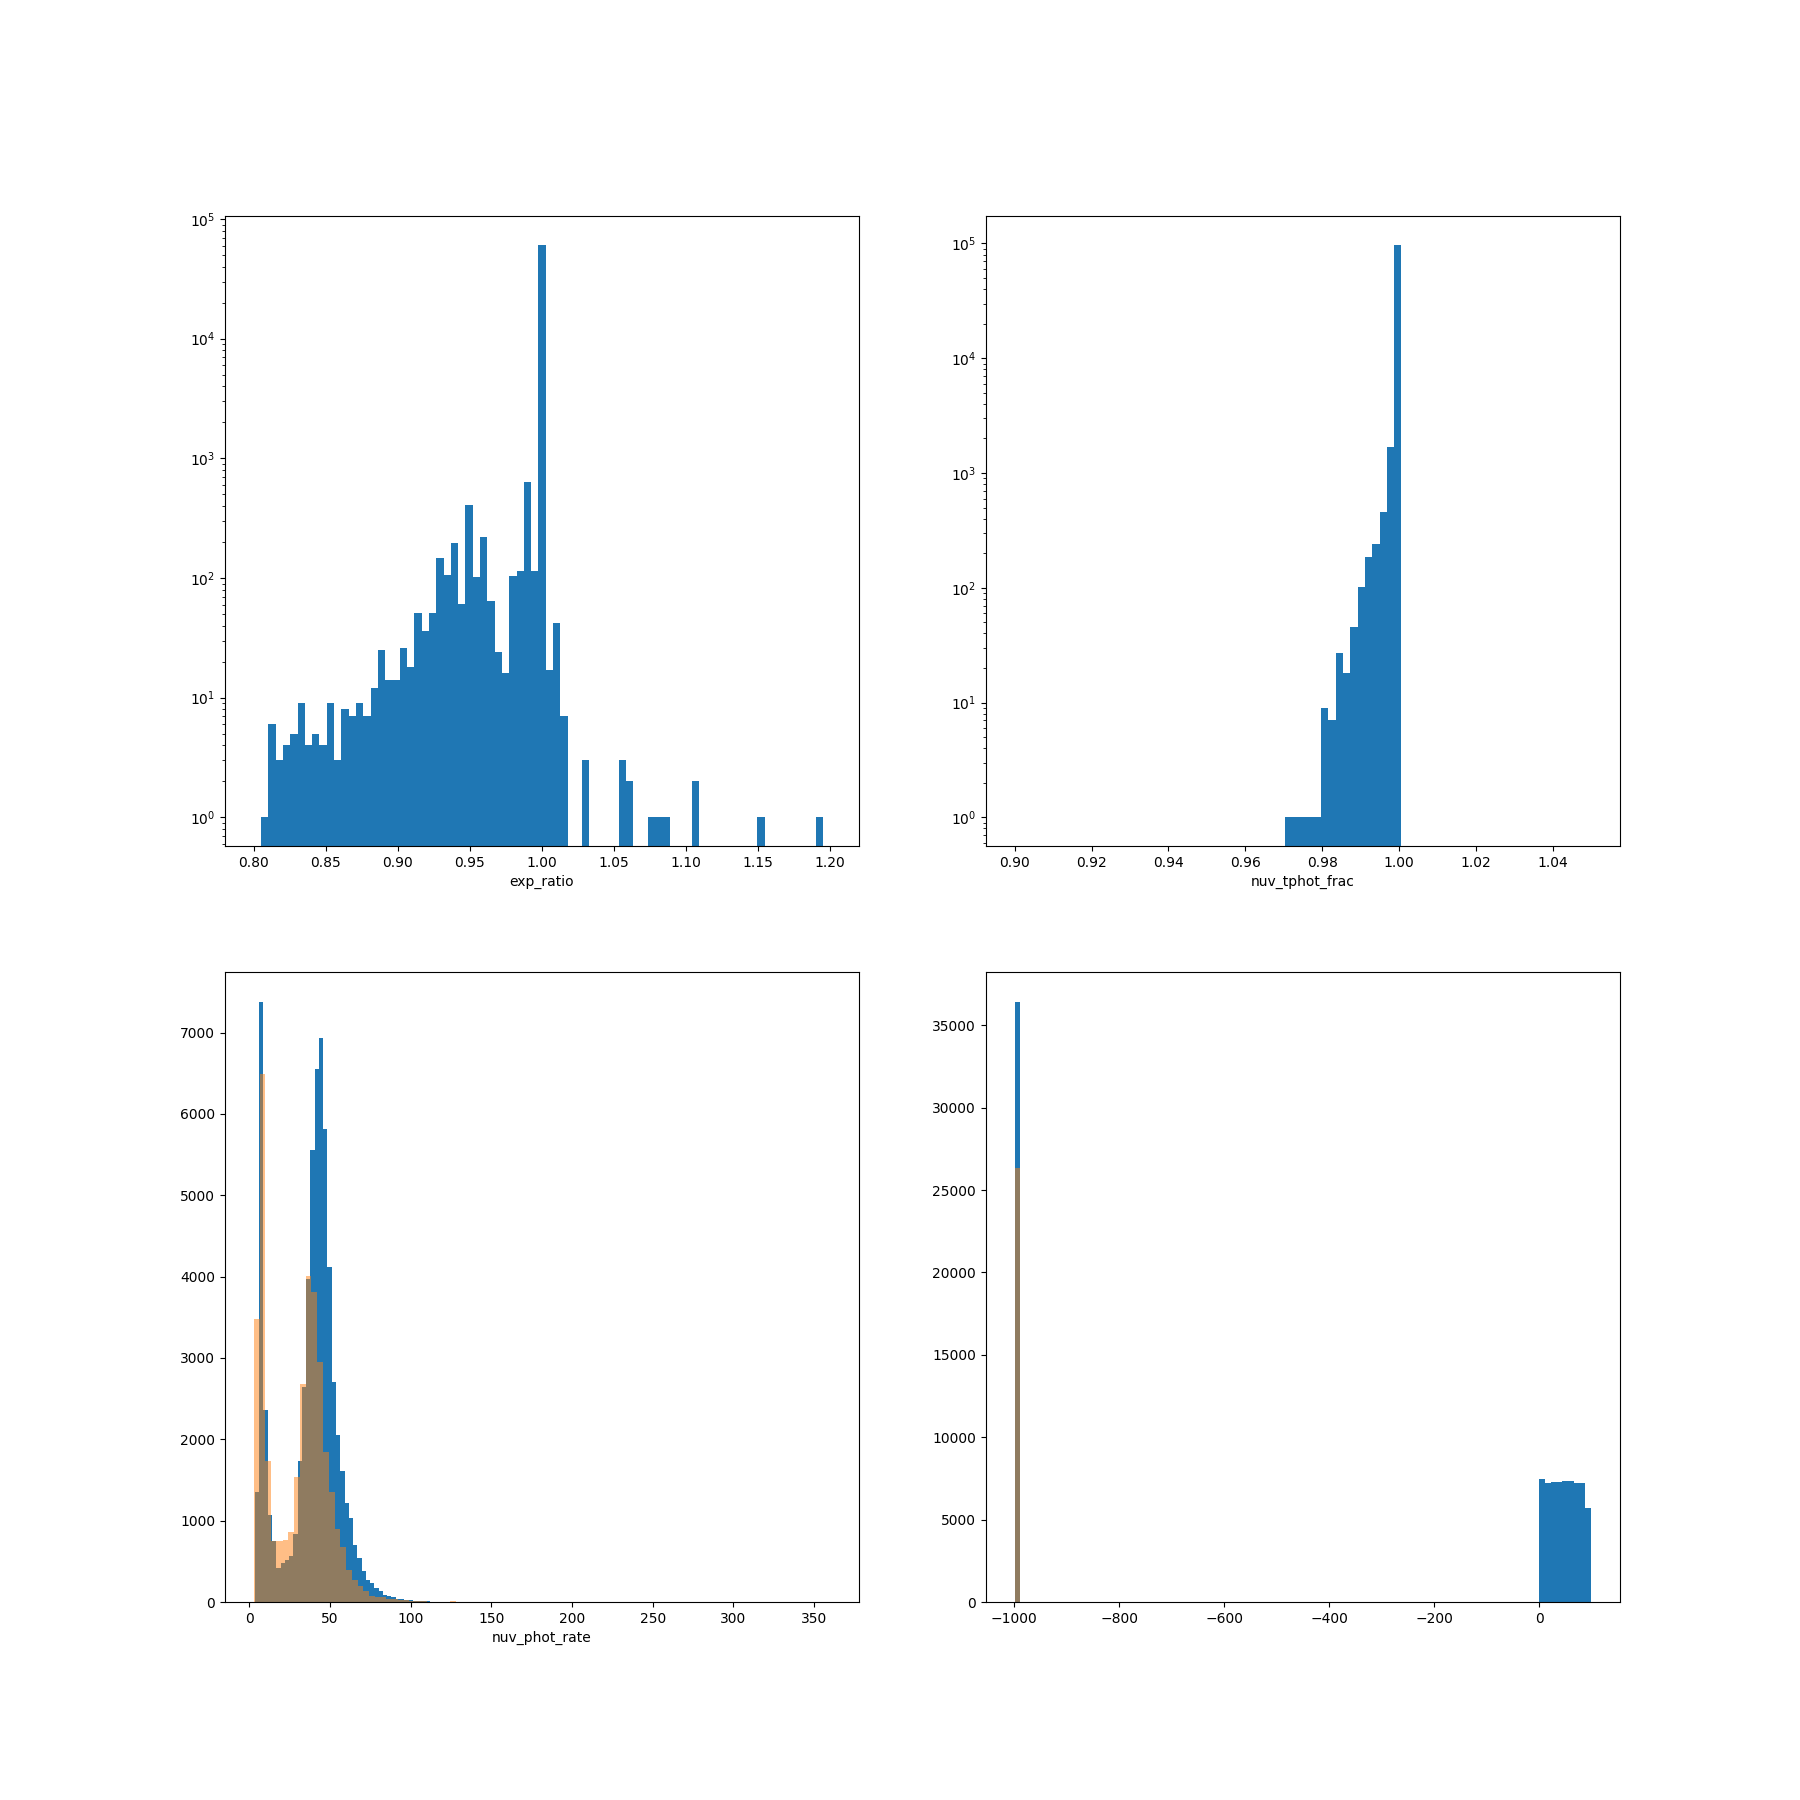

RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,source,nPhotoObjects,nPhotoVisits,PhotoObsDate,spectra,nSpectra,nSpectraVisits,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb,exp_ratio,minPhotoObsDate_MJD,maxPhotoObsDate_MJD,nuv_tphot_frac,nuv_phot_rate
float64,float64,bytes3,float64,float64,int64,int64,int64,int64,int64,bytes6,int64,int64,bytes22,bytes5,bytes4,bytes4,bytes4,int64,int64,bytes22,bytes22,bytes4,bytes4,float64,float64,float64,float64,float64,float64,float64,float64
252.008807733942,74.6508357683335,AIS,105.1,0.0,6370915683546431488,6370915820985384960,98323,50000,-999,visitI,4078,1,1/15/2005 10:50:08 PM,False,null,null,null,1,61,1/15/2005 10:50:08 PM,1/15/2005 10:51:53 PM,null,null,53385.95148148148,107.0052040758992,34.09213548632806,0.0,53385.95148148148,53385.95269675926,0.9990485254799208,38.801141769743104
249.941640486216,75.4193969401424,AIS,95.05,0.0,6370915672809013248,6370915810247966720,95512,50000,-999,visitI,3737,1,1/15/2005 10:52:34 PM,False,null,null,null,1,51,1/15/2005 10:52:34 PM,1/15/2005 10:54:09 PM,null,null,53385.9531712963,108.11620290620547,34.26725568507652,0.0,53385.9531712963,53385.95427083333,0.9994739566149209,39.316149395055234
252.028393967596,74.6633348338686,AIS,105.0,105.0,6370915683579985920,6370915820985384960,55961,50000,-999,visitI,4516,1,3/6/2005 11:16:07 AM,False,null,null,null,2,61,3/6/2005 11:16:07 AM,3/6/2005 11:17:52 AM,null,null,53435.46952546296,107.01671619626627,34.08253423375247,1.0,53435.46952546296,53435.47074074074,1.0000000002660923,43.00952380952381
249.839363522886,75.3986822117263,AIS,106.0,106.0,6370915672842567680,6370915810247966720,80953,50000,-999,visitI,4239,1,3/6/2005 11:18:29 AM,False,null,null,null,2,51,3/6/2005 11:18:29 AM,3/6/2005 11:20:15 AM,null,null,53435.47116898148,108.10690090987147,34.29940962579424,1.0,53435.47116898148,53435.472395833334,1.0000000024688833,39.990566037735846
251.940981782764,74.6646117199625,AIS,77.0,0.0,6370915683613540352,6370915820985384960,6848,50000,-999,visitI,3856,1,4/26/2005 10:12:25 AM,False,null,null,null,3,61,4/26/2005 10:12:25 AM,4/26/2005 10:13:42 AM,null,null,53486.42528935185,107.02892075058935,34.103365835460025,0.0,53486.42528935185,53486.42618055556,1.000000005164607,50.077922077922075
249.858478052049,75.4021910488644,AIS,88.0,0.0,6370915672876122112,6370915810247966720,75273,50000,-999,visitI,4018,1,4/26/2005 10:14:17 AM,False,null,null,null,3,51,4/26/2005 10:14:17 AM,4/26/2005 10:15:45 AM,null,null,53486.42658564815,108.10823692866653,34.29355238342048,0.0,53486.42658564815,53486.42760416667,0.9999999980209395,45.65909090909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197.064229492048,-31.2550202940073,AIS,272.0,0.0,6388191240407482368,6388191377745772544,92294,50491,-999,visitI,5266,1,5/12/2011 3:53:13 PM,False,null,null,null,4,89,5/12/2011 3:53:13 PM,5/12/2011 3:57:45 PM,null,null,55693.66195601852,307.14672933307463,31.479046758458576,0.0,55693.66195601852,55693.66510416667,1.000000000332126,19.360294117647058
200.507678993805,-27.9068593141909,AIS,236.0,0.0,6388191209201860608,6388191346607259648,38389,50491,-999,visitI,4903,1,5/13/2011 12:51:05 PM,False,null,null,null,2,60,5/13/2011 12:51:05 PM,5/13/2011 12:55:01 PM,null,null,55694.535474537035,311.13450041374995,34.477159312671034,0.0,55694.535474537035,55694.53820601852,1.0000000020165503,20.77542372881356


Total Nr of visits 100509


In [6]:
from datetime import datetime
from astropy.time import Time

#Read visit  table
tt_vis = Table.read("/home/buehler/Data/galex/GALEX_visits_list/GALEX_visits_list.fits")
tt_vis = tt_vis[tt_vis["nexptime"]>1]


#Add variables
tt_vis["exp_ratio"] = tt_vis["fexptime"]/tt_vis["nexptime"]

# Add times
ll_tmin = [
    datetime.strptime(date_str.decode("utf-8"), "%m/%d/%Y %I:%M:%S %p")
    for date_str in tt_vis["minPhotoObsDate"].data
]
tt_vis["minPhotoObsDate_MJD"] = Time(ll_tmin).mjd

ll_tmax = [
    datetime.strptime(date_str.decode("utf-8"), "%m/%d/%Y %I:%M:%S %p")
    for date_str in tt_vis["maxPhotoObsDate"].data
]
tt_vis["maxPhotoObsDate_MJD"] = Time(ll_tmax).mjd

tt_vis["nuv_tphot_frac"] = ( (tt_vis["maxPhotoObsDate_MJD"]-tt_vis["minPhotoObsDate_MJD"])*24*60*60) / tt_vis["nexptime"]

tt_vis["nuv_phot_rate"] = tt_vis["nPhotoObjects"]/tt_vis["nexptime"]

figv, axsv = plt.subplots(2,2,figsize=(18,18), squeeze=True, num="visit", clear=True) 
axsv = axsv.flatten()

axsv[0].hist(tt_vis["exp_ratio"],bins=np.linspace(0.8,1.2,80))
axsv[0].set_xlabel("exp_ratio")
axsv[0].set_yscale("log")

axsv[1].hist(tt_vis["nuv_tphot_frac"],bins=np.linspace(0.9,1.05,80))
axsv[1].set_xlabel("nuv_tphot_frac")
axsv[1].set_yscale("log")

axsv[2].hist(tt_vis["nuv_phot_rate"][tt_vis["fexptime"]>1],bins=100)
axsv[2].hist(tt_vis["nuv_phot_rate"][tt_vis["fexptime"]<1],bins=100, alpha=0.5)
axsv[2].set_xlabel("nuv_phot_rate")
#axsv[2].set_yscale("log")

axsv[3].hist(tt_vis["subvis"],bins=100)
axsv[3].hist(tt_vis["subvis"][tt_vis["nuv_phot_rate"] <20],bins=100, alpha=0.5)
#axsv[3].set_xlabel("nuv_tphot_frac")

plt.show()

display(tt_vis[tt_vis["subvis"]>0])
print("Total Nr of visits",len(tt_vis))

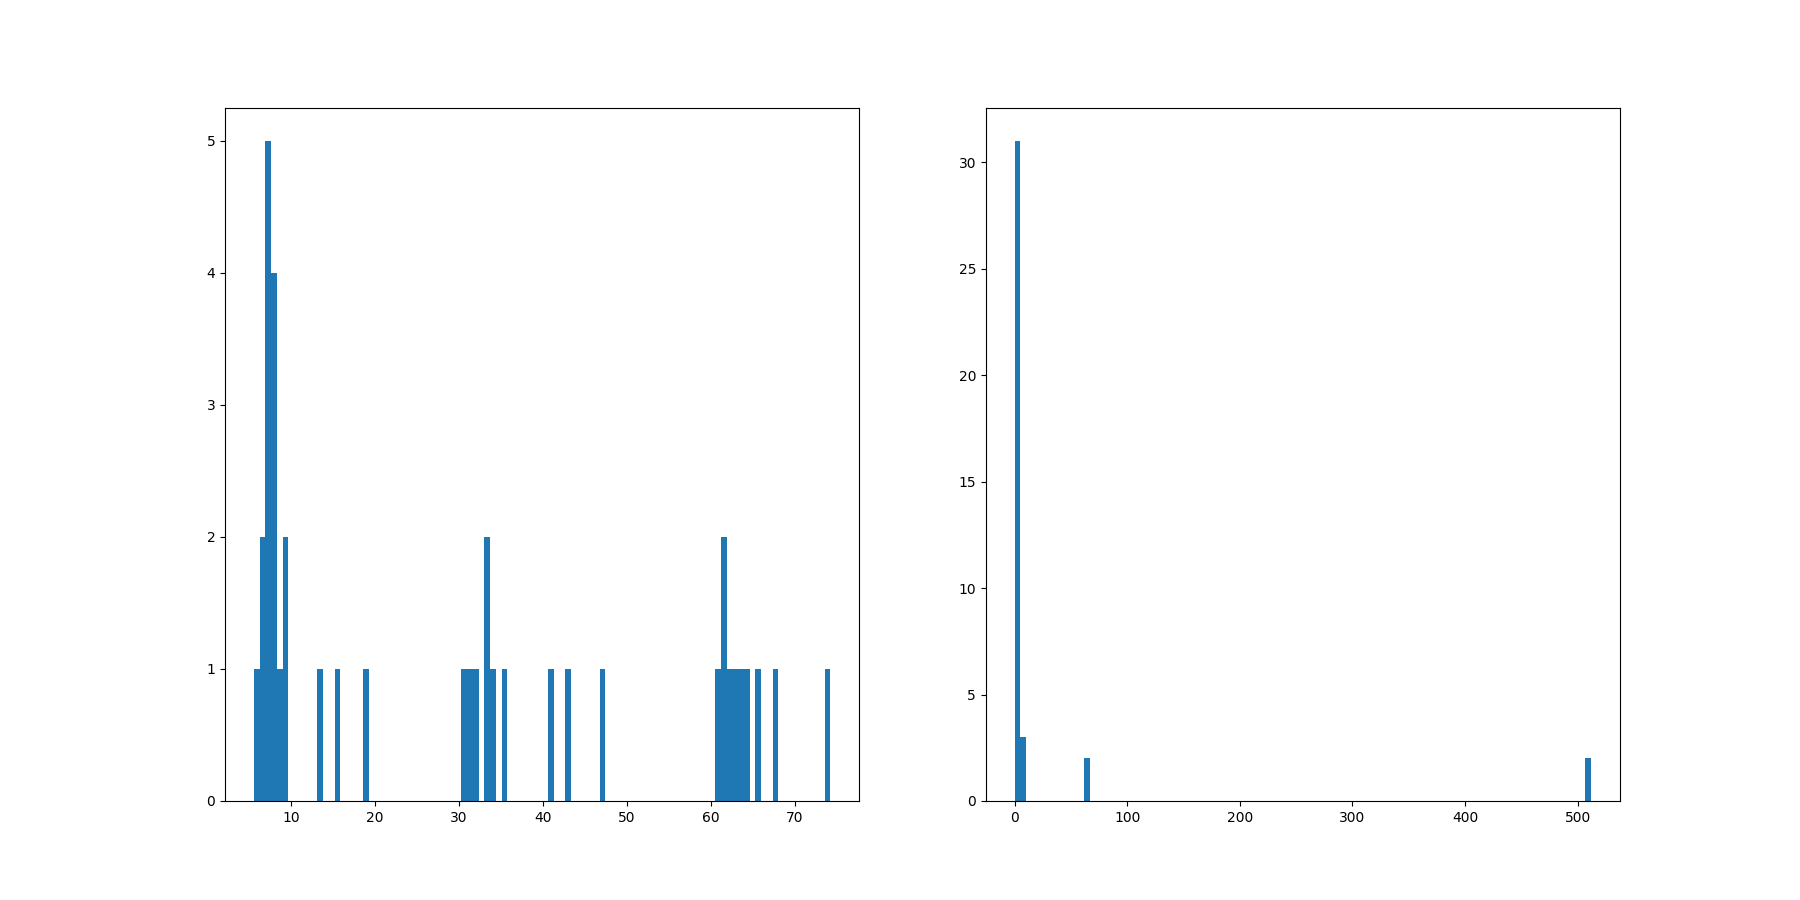

time_gp,time_bin_size_gp,flux_gp,flux_err_gp,sel_gp,obs_filter_gp,obs_filter_id,flags,s2n,rg_src_id,rtime,time_src,time_bin_size_src,flux_src,flux_err_src,ul,sel_src,obs_filter_src,r_fov,artifacts,class_star,chkobj_type,size_world,ellip_world,flux_auto,flux_auto_err,pull,pull_auto,rrtime,RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,source,nPhotoObjects,nPhotoVisits,PhotoObsDate,spectra,nSpectra,nSpectraVisits,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb,exp_ratio,minPhotoObsDate_MJD,maxPhotoObsDate_MJD,nuv_tphot_frac,nuv_phot_rate
d,s,1e-06 Jy,1e-06 Jy,,,,,,,,d,s,1e-06 Jy,1e-06 Jy,1e-06 Jy,,,deg,,,,arcsec,,Jy,Jy,1e-06 Jy,1e-06 Jy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float32,float32,float32,bool,bytes8,int32,int64,float32,int64,float64,float64,float32,float32,float32,float32,bool,bytes8,float32,int64,float32,int32,float32,float32,float32,float32,float32,float32,float64,float64,float64,bytes3,float64,float64,int64,int64,int64,int64,int64,bytes6,int64,int64,bytes22,bytes5,bytes4,bytes4,bytes4,int64,int64,bytes22,bytes22,bytes4,bytes4,float64,float64,float64,float64,float64,float64,float64,float64
54238.0775115162,644.0,1.0855803,3.1530795,False,FUV,2,0,1.8897305,305192,54238.08,54238.07748842586,640.0,4.1970835,0.62730455,-1.0,True,FUV,0.27952293,0,0.9835763,0,2.3278174,0.26246935,3.9480472,0.59571826,-4.9601154,-4.805068,54238.1,254.08940716776,-6.18401358051845,AIS,112.0,112.0,6383441324305022976,6383441461743976448,58522,50356,-999,visitI,3774,1,5/18/2007 3:21:13 AM,False,null,null,null,1,65,5/18/2007 3:21:13 AM,5/18/2007 3:23:05 AM,null,null,54238.1397337963,13.113691608983686,22.131622162468442,1.0,54238.1397337963,54238.14103009259,0.9999999980209395,33.69642857142857
54238.0775115162,644.0,1.0855803,3.1530795,False,FUV,2,0,1.8897305,305192,54238.08,54238.07748842586,640.0,4.1970835,0.62730455,-1.0,True,FUV,0.27952293,0,0.9835763,0,2.3278174,0.26246935,3.9480472,0.59571826,-4.9601154,-4.805068,54238.1,251.47409327776,-5.42389415531819,AIS,112.0,112.0,6383441289945284608,6383441427384238080,94755,50356,-999,visitI,3471,1,5/18/2007 3:13:59 AM,False,null,null,null,1,33,5/18/2007 3:13:59 AM,5/18/2007 3:15:51 AM,null,null,54238.13471064815,12.267429035910997,24.728701838334416,1.0,54238.13471064815,54238.13600694444,0.9999999980209395,30.991071428571427
54238.0775115162,644.0,1.0855803,3.1530795,False,FUV,2,0,1.8897305,305192,54238.08,54238.07748842586,640.0,4.1970835,0.62730455,-1.0,True,FUV,0.27952293,0,0.9835763,0,2.3278174,0.26246935,3.9480472,0.59571826,-4.9601154,-4.805068,54238.1,251.996558995611,-6.28418915235113,AIS,85.15,85.15,6383441301756444672,6383441439195398144,90218,50356,-999,visitI,3639,1,5/18/2007 3:16:36 AM,False,null,null,null,1,44,5/18/2007 3:16:36 AM,5/18/2007 3:18:01 AM,null,null,54238.13652777778,11.791710940514436,23.821959003285667,1.0,54238.13652777778,54238.137511574074,0.9982383999201352,42.736347621843805
54238.0775115162,644.0,1.0855803,3.1530795,False,FUV,2,0,1.8897305,305192,54238.08,54238.07748842586,640.0,4.1970835,0.62730455,-1.0,True,FUV,0.27952293,0,0.9835763,0,2.3278174,0.26246935,3.9480472,0.59571826,-4.9601154,-4.805068,54238.1,253.046844170698,-6.22759159458042,AIS,112.0,112.0,6383441313567604736,6383441451006558208,44296,50356,-999,visitI,3733,1,5/18/2007 3:18:49 AM,False,null,null,null,1,55,5/18/2007 3:18:49 AM,5/18/2007 3:20:41 AM,null,null,54238.13806712963,12.465917759611086,22.979131373708718,1.0,54238.13806712963,54238.13936342593,1.000000003633821,33.330357142857146
54238.0775115162,644.0,1.0855803,3.1530795,False,FUV,2,0,1.8897305,305192,54238.08,54238.07748842586,640.0,4.1970835,0.62730455,-1.0,True,FUV,0.27952293,0,0.9835763,0,2.3278174,0.26246935,3.9480472,0.59571826,-4.9601154,-4.805068,54238.1,255.153303382336,-6.13962596454486,AIS,42.05,42.05,6383441335042441216,6383441472481394688,43465,50356,-999,visitI,2843,1,5/18/2007 3:24:31 AM,False,n

time_gp,time_bin_size_gp,flux_gp,flux_err_gp,sel_gp,obs_filter_gp,obs_filter_id,flags,s2n,rg_src_id,rtime,time_src,time_bin_size_src,flux_src,flux_err_src,ul,sel_src,obs_filter_src,r_fov,artifacts,class_star,chkobj_type,size_world,ellip_world,flux_auto,flux_auto_err,pull,pull_auto,rrtime,RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,source,nPhotoObjects,nPhotoVisits,PhotoObsDate,spectra,nSpectra,nSpectraVisits,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb,exp_ratio,minPhotoObsDate_MJD,maxPhotoObsDate_MJD,nuv_tphot_frac,nuv_phot_rate
d,s,1e-06 Jy,1e-06 Jy,,,,,,,,d,s,1e-06 Jy,1e-06 Jy,1e-06 Jy,,,deg,,,,arcsec,,Jy,Jy,1e-06 Jy,1e-06 Jy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float32,float32,float32,bool,bytes8,int32,int64,float32,int64,float64,float64,float32,float32,float32,float32,bool,bytes8,float32,int64,float32,int32,float32,float32,float32,float32,float32,float32,float64,float64,float64,bytes3,float64,float64,int64,int64,int64,int64,int64,bytes6,int64,int64,bytes22,bytes5,bytes4,bytes4,bytes4,int64,int64,bytes22,bytes22,bytes4,bytes4,float64,float64,float64,float64,float64,float64,float64,float64
54248.82604739583,1159.0,2.08548,1.0586996,True,FUV,2,0,3.4037616,305192,54248.83,54248.82603038227,1156.05,4.6988597,0.50240827,-1.0,True,FUV,0.23455438,0,0.9833634,0,2.2639055,0.16294107,4.219982,0.47350925,-5.2017055,-4.5078363,54248.8,219.157472772279,28.3334206493591,AIS,64.0,64.0,6379254367987433472,6379254505359278080,26746,50237,-999,visitI,4073,1,5/28/2007 6:12:30 PM,False,null,null,null,3,50,5/28/2007 6:12:30 PM,5/28/2007 6:13:34 PM,null,null,54248.758680555555,42.04771054835131,66.7370126352766,1.0,54248.758680555555,54248.759421296294,0.9999999980209395,63.640625
54248.82604739583,1159.0,2.08548,1.0586996,True,FUV,2,0,3.4037616,305192,54248.83,54248.82603038227,1156.05,4.6988597,0.50240827,-1.0,True,FUV,0.23455438,0,0.9833634,0,2.2639055,0.16294107,4.219982,0.47350925,-5.2017055,-4.5078363,54248.8,217.533625509843,26.099543846048,AIS,61.0,61.0,6378515445640593408,6378515583079546880,55410,50216,-999,visitI,3920,1,5/28/2007 6:02:46 PM,False,null,null,null,1,3,5/28/2007 6:02:46 PM,5/28/2007 6:03:47 PM,null,null,54248.751921296294,35.899473615017484,67.95140464171436,1.0,54248.751921296294,54248.75262731482,1.000000007038356,64.26229508196721
54248.82604739583,1159.0,2.08548,1.0586996,True,FUV,2,0,3.4037616,305192,54248.83,54248.82603038227,1156.05,4.6988597,0.50240827,-1.0,True,FUV,0.23455438,0,0.9833634,0,2.2639055,0.16294107,4.219982,0.47350925,-5.2017055,-4.5078363,54248.8,214.916590987148,26.8701902924083,AIS,91.0,91.0,6379289557661122560,6379289695100076032,20387,50238,-999,visitI,4301,1,5/28/2007 6:19:00 PM,False,null,null,null,1,55,5/28/2007 6:19:00 PM,5/28/2007 6:20:31 PM,null,null,54248.763194444444,37.24527761127507,70.37046492796739,1.0,54248.763194444444,54248.76424768518,0.9999999988844598,47.26373626373626
54248.82604739583,1159.0,2.08548,1.0586996,True,FUV,2,0,3.4037616,305192,54248.83,54248.82603038227,1156.05,4.6988597,0.50240827,-1.0,True,FUV,0.23455438,0,0.9833634,0,2.2639055,0.16294107,4.219982,0.47350925,-5.2017055,-4.5078363,54248.8,217.085494446043,26.8801860746765,AIS,61.05,61.05,6379289601684537344,6379289739123490816,20434,50238,-999,visitI,3843,1,5/28/2007 6:07:37 PM,False,null,null,null,1,96,5/28/2007 6:07:37 PM,5/28/2007 6:08:38 PM,null,null,54248.75528935185,37.849168127645406,68.44748374405245,1.0,54248.75528935185,54248.75599537037,0.9991809959164123,62.94840294840295
54248.82604739583,1159.0,2.08548,1.0586996,True,FUV,2,0,3.4037616,305192,54248.83,54248.82603038227,1156.05,4.6988597,0.50240827,-1.0,True,FUV,0.23455438,0,0.9833634,0,2.2639055,0.16294107,4.219982,0.47350925,-5.2017055,-4.5078363,54248.8,218.614727017562,26.4103414729756,AIS,57.0,57.0,6379254370067808256,6379254507506761728,27914,50237,-999,visitI,3737,1,5/28/2007 6:01:12 PM,False,null,null,null,1,52

In [5]:
tt_lc_both["rrtime"]=np.round(tt_lc_both["rtime"],1)
tt_vis["rrtime"] = np.round((tt_vis["maxPhotoObsDate_MJD"]+tt_vis["minPhotoObsDate_MJD"])/2.,1)

tt_lc_vis = join(tt_lc_both,tt_vis,keys=["rrtime"],join_type='inner')
sel_pull = np.abs(tt_lc_vis["pull"])>4.

figvl, axsvl = plt.subplots(1,2,figsize=(18,9), squeeze=True, num="visitlc", clear=True) 
axsvl = axsvl.flatten()

axsvl[0].hist(tt_lc_vis["nuv_phot_rate"][sel_pull],bins=100)
axsvl[1].hist(tt_lc_vis["flags"][sel_pull],bins=100)
plt.show()

display(tt_lc_vis[sel_pull][tt_lc_vis["nuv_phot_rate"][sel_pull]>25][:10])#
display(tt_lc_vis[sel_pull][tt_lc_vis["nuv_phot_rate"][sel_pull]>25][10:])